In [13]:
# Importo le librerie
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [14]:
# 1. Caricamento del dataset
result = pyreadr.read_r("../Data/dataset_final.rds")
data = result[None]
target = data['bacteremia']

# SE VOGLIO SELEZIONARE MANUALMENTE LE FEATURE
#selected_columns = ['sodium', 'phos', 'mg', 'crea', 'bun', 'hs', 'tp', 'ap', 'ggt', 'ck', 'glu', 'crp', 'neu', 'neur']  # METTERE QUI I NOMI DELLE COLONNE DA INCLUDERE
selected_columns = ['sodium', 'phos', 'crea', 'bun', 'hs', 'tp', 'ap', 'ggt', 'glu', 'neur']
#selected_columns = ['crea', 'hs', 'ap', 'ggt', 'glu']
features = data[selected_columns]

# SE VOGLIO INCLUDERE TUTTE LE FEATURE
#features = data.drop(columns = ['bacteremia','id','sex'])

# Normalizzo le feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Divido il dataset: training set (solo classe 0) e test set (tutti i dati)
X_train = X_scaled[target == 0]  # Addestriamo l'autoencoder solo con classe 0
X_test = X_scaled  # Usiamo tutti i dati per il test
y_test = target

In [15]:
import optuna
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError

# Funzione per costruire l'autoencoder ottimizzato
def create_autoencoder(trial, input_dim):
    # Encoder con iperparametri ottimizzati
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(trial.suggest_int('encoder_units_1', 64, 512), activation='relu')(input_layer)
    encoded = Dropout(trial.suggest_float('dropout_1', 0.1, 0.9))(encoded)
    encoded = Dense(trial.suggest_int('encoder_units_2', 32, 256), activation='relu')(encoded)
    encoded = Dropout(trial.suggest_float('dropout_2', 0.1, 0.9))(encoded)
    encoded = Dense(trial.suggest_int('encoder_units_3', 16, 128), activation='relu')(encoded)
    encoded = Dropout(trial.suggest_float('dropout_3', 0.1, 0.9))(encoded)
    encoded = Dense(trial.suggest_int('encoder_units_4', 8, 64), activation='relu')(encoded)

    # Bottleneck
    bottleneck = Dense(trial.suggest_int('bottleneck', 1, 64), activation='relu')(encoded)

    # Decoder
    decoded = Dense(trial.suggest_int('decoder_units_1', 8, 64), activation='relu')(bottleneck)
    decoded = Dropout(trial.suggest_float('dropout_4', 0.1, 0.9))(decoded)
    decoded = Dense(trial.suggest_int('decoder_units_2', 16, 128), activation='relu')(bottleneck)
    decoded = Dropout(trial.suggest_float('dropout_5', 0.1, 0.9))(decoded)
    decoded = Dense(trial.suggest_int('decoder_units_3', 32, 256), activation='relu')(decoded)
    decoded = Dropout(trial.suggest_float('dropout_6', 0.1, 0.9))(decoded)
    decoded = Dense(trial.suggest_int('decoder_units_4', 64, 512), activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    # Costruzione del modello
    autoencoder = Model(inputs=input_layer, outputs=output_layer)

    # Compilazione con ottimizzatore adattivo
    optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))
    autoencoder.compile(optimizer=optimizer, loss=MeanSquaredError())

    return autoencoder

In [16]:
# Funzione di obiettivo per Optuna (ottimizzazione di autoencoder + soglia)
def objective(trial):
    input_dim = X_train.shape[1]  # Numero di feature

    # Creazione del modello con i parametri ottimizzati
    autoencoder = create_autoencoder(trial, input_dim)

    # Aggiungi EarlyStopping per fermare l'addestramento se la validazione non migliora
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Addestramento del modello con i parametri ottimizzati
    autoencoder.fit(
        X_train, X_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        verbose=0,  # Impostato su 0 per non avere troppa stampa
        callbacks=[early_stopping]
    )

    # Predizione dell'errore di ricostruzione
    X_test_pred = autoencoder.predict(X_test)
    reconstruction_error = np.mean((X_test - X_test_pred) ** 2, axis=1)

    # Ottimizzazione della soglia tramite Optuna
    #threshold = trial.suggest_float('threshold', 0.7, 0.99)  # Ottimizza la soglia per l'errore di ricostruzione

    # Classificazione delle anomalie usando la soglia ottimizzata
    #y_pred = (reconstruction_error > threshold).astype(int)

    # Calcolare l'AUC-ROC
    auc = roc_auc_score(y_test, reconstruction_error)

    return auc  # Obiettivo: massimizzare l'AUC-ROC

# Ottimizzazione con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Stampa dei migliori parametri
best_params = study.best_trial.params
print(f"Best parameters: {best_params}")

# Creazione del modello finale con i migliori parametri
final_autoencoder = create_autoencoder(best_params, X_train.shape[1])

# Addestramento finale con i migliori parametri
final_autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Predizione finale e valutazione delle performance
X_test_pred = final_autoencoder.predict(X_test)
reconstruction_error = np.mean((X_test - X_test_pred) ** 2, axis=1)

# Classificazione delle anomalie usando la soglia ottimizzata
final_threshold = best_params['threshold']
y_pred = (reconstruction_error > final_threshold).astype(int)

# Calcolare le metriche di valutazione
auc = roc_auc_score(y_test, reconstruction_error)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"AUC-ROC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

[I 2025-02-04 19:10:30,267] A new study created in memory with name: no-name-0831f03d-0e97-4e0d-a2b0-808c09978de9
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 2s 3ms/step


[I 2025-02-04 19:11:16,445] Trial 0 finished with value: 0.6185124749973681 and parameters: {'encoder_units_1': 403, 'dropout_1': 0.18244017861554643, 'encoder_units_2': 244, 'dropout_2': 0.5645661928841185, 'encoder_units_3': 29, 'dropout_3': 0.6165322160875519, 'encoder_units_4': 20, 'bottleneck': 11, 'decoder_units_1': 58, 'dropout_4': 0.28660124256328334, 'decoder_units_2': 52, 'dropout_5': 0.45783773248832527, 'decoder_units_3': 211, 'dropout_6': 0.11442492287132221, 'decoder_units_4': 262, 'lr': 0.11465896563470197}. Best is trial 0 with value: 0.6185124749973681.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 2s 3ms/step


[I 2025-02-04 19:11:59,804] Trial 1 finished with value: 0.6177162189321364 and parameters: {'encoder_units_1': 388, 'dropout_1': 0.8306560148847234, 'encoder_units_2': 228, 'dropout_2': 0.23097571419538632, 'encoder_units_3': 62, 'dropout_3': 0.7071858918915651, 'encoder_units_4': 41, 'bottleneck': 40, 'decoder_units_1': 20, 'dropout_4': 0.6857558335202965, 'decoder_units_2': 104, 'dropout_5': 0.5228463272031794, 'decoder_units_3': 153, 'dropout_6': 0.6068322284820759, 'decoder_units_4': 369, 'lr': 0.02527386965044532}. Best is trial 0 with value: 0.6185124749973681.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 19:14:50,858] Trial 2 finished with value: 0.6428897505273966 and parameters: {'encoder_units_1': 112, 'dropout_1': 0.41992154548479665, 'encoder_units_2': 117, 'dropout_2': 0.8138702226115884, 'encoder_units_3': 114, 'dropout_3': 0.45490262151017524, 'encoder_units_4': 35, 'bottleneck': 46, 'decoder_units_1': 50, 'dropout_4': 0.7044303034379389, 'decoder_units_2': 75, 'dropout_5': 0.32239286247721044, 'decoder_units_3': 180, 'dropout_6': 0.576878309551418, 'decoder_units_4': 84, 'lr': 0.0004254841832710422}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 21:43:48,436] Trial 3 finished with value: 0.6120460390225629 and parameters: {'encoder_units_1': 123, 'dropout_1': 0.6945071804866833, 'encoder_units_2': 140, 'dropout_2': 0.4126363397399374, 'encoder_units_3': 106, 'dropout_3': 0.7562168937003308, 'encoder_units_4': 22, 'bottleneck': 54, 'decoder_units_1': 23, 'dropout_4': 0.17600806542395153, 'decoder_units_2': 31, 'dropout_5': 0.4857070998092594, 'decoder_units_3': 40, 'dropout_6': 0.8535890657605215, 'decoder_units_4': 88, 'lr': 0.12629505541529}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 21:44:12,096] Trial 4 finished with value: 0.615929838137439 and parameters: {'encoder_units_1': 440, 'dropout_1': 0.7071587221546202, 'encoder_units_2': 195, 'dropout_2': 0.38214214203027497, 'encoder_units_3': 58, 'dropout_3': 0.8200108810785265, 'encoder_units_4': 25, 'bottleneck': 47, 'decoder_units_1': 46, 'dropout_4': 0.3143505934019082, 'decoder_units_2': 127, 'dropout_5': 0.2396031861252757, 'decoder_units_3': 187, 'dropout_6': 0.8878546907218124, 'decoder_units_4': 327, 'lr': 0.05569719837088275}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 21:44:40,688] Trial 5 finished with value: 0.6170430790390786 and parameters: {'encoder_units_1': 112, 'dropout_1': 0.7962937886450464, 'encoder_units_2': 190, 'dropout_2': 0.6708513871750816, 'encoder_units_3': 101, 'dropout_3': 0.29139980104868923, 'encoder_units_4': 40, 'bottleneck': 1, 'decoder_units_1': 26, 'dropout_4': 0.3606429380277628, 'decoder_units_2': 54, 'dropout_5': 0.7062629643751642, 'decoder_units_3': 33, 'dropout_6': 0.7501815992823765, 'decoder_units_4': 298, 'lr': 0.008698514761947987}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 21:45:13,939] Trial 6 finished with value: 0.6240909842867944 and parameters: {'encoder_units_1': 243, 'dropout_1': 0.14415733710136636, 'encoder_units_2': 159, 'dropout_2': 0.2052290620788771, 'encoder_units_3': 66, 'dropout_3': 0.8906692216005795, 'encoder_units_4': 46, 'bottleneck': 61, 'decoder_units_1': 63, 'dropout_4': 0.12549191403608512, 'decoder_units_2': 24, 'dropout_5': 0.5016242972329485, 'decoder_units_3': 59, 'dropout_6': 0.400961549415658, 'decoder_units_4': 282, 'lr': 2.3636094479424927e-05}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 21:46:36,195] Trial 7 finished with value: 0.6353048782988776 and parameters: {'encoder_units_1': 268, 'dropout_1': 0.6947616864212015, 'encoder_units_2': 39, 'dropout_2': 0.46720644493185526, 'encoder_units_3': 93, 'dropout_3': 0.6160531958341923, 'encoder_units_4': 45, 'bottleneck': 33, 'decoder_units_1': 29, 'dropout_4': 0.15689446787443925, 'decoder_units_2': 70, 'dropout_5': 0.3111721681847742, 'decoder_units_3': 135, 'dropout_6': 0.7830479259604598, 'decoder_units_4': 259, 'lr': 0.0020193285500580294}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 21:47:22,378] Trial 8 finished with value: 0.6293157311159205 and parameters: {'encoder_units_1': 240, 'dropout_1': 0.4796815128235825, 'encoder_units_2': 98, 'dropout_2': 0.1731588171080844, 'encoder_units_3': 123, 'dropout_3': 0.6194362728158689, 'encoder_units_4': 58, 'bottleneck': 2, 'decoder_units_1': 60, 'dropout_4': 0.6297209325996653, 'decoder_units_2': 121, 'dropout_5': 0.16712338014276373, 'decoder_units_3': 110, 'dropout_6': 0.20859002479303515, 'decoder_units_4': 471, 'lr': 0.0016358282088594677}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 21:47:46,167] Trial 9 finished with value: 0.6256390624850463 and parameters: {'encoder_units_1': 472, 'dropout_1': 0.719863350549231, 'encoder_units_2': 92, 'dropout_2': 0.20358133891951163, 'encoder_units_3': 76, 'dropout_3': 0.6428790879032712, 'encoder_units_4': 43, 'bottleneck': 7, 'decoder_units_1': 39, 'dropout_4': 0.24202331395769675, 'decoder_units_2': 76, 'dropout_5': 0.7576721814121573, 'decoder_units_3': 177, 'dropout_6': 0.6142774846898382, 'decoder_units_4': 477, 'lr': 7.280377064020934e-05}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 21:49:41,751] Trial 10 finished with value: 0.6146134999856444 and parameters: {'encoder_units_1': 173, 'dropout_1': 0.38505370928397853, 'encoder_units_2': 42, 'dropout_2': 0.8169496370486743, 'encoder_units_3': 126, 'dropout_3': 0.3977125611995954, 'encoder_units_4': 9, 'bottleneck': 25, 'decoder_units_1': 11, 'dropout_4': 0.8698373460860074, 'decoder_units_2': 95, 'dropout_5': 0.3055630947389405, 'decoder_units_3': 251, 'dropout_6': 0.3933710055185057, 'decoder_units_4': 71, 'lr': 3.532702962501081e-07}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 21:50:02,173] Trial 11 finished with value: 0.6289280621473484 and parameters: {'encoder_units_1': 190, 'dropout_1': 0.5554537839905125, 'encoder_units_2': 34, 'dropout_2': 0.8959993243409792, 'encoder_units_3': 93, 'dropout_3': 0.12965418869969864, 'encoder_units_4': 56, 'bottleneck': 29, 'decoder_units_1': 46, 'dropout_4': 0.47550761296257454, 'decoder_units_2': 70, 'dropout_5': 0.32308968570927155, 'decoder_units_3': 104, 'dropout_6': 0.6885343443466004, 'decoder_units_4': 189, 'lr': 0.0004958048114891537}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 21:52:11,108] Trial 12 finished with value: 0.6213695768385735 and parameters: {'encoder_units_1': 328, 'dropout_1': 0.3326469537579021, 'encoder_units_2': 93, 'dropout_2': 0.6590622154491765, 'encoder_units_3': 89, 'dropout_3': 0.446978507270977, 'encoder_units_4': 31, 'bottleneck': 38, 'decoder_units_1': 34, 'dropout_4': 0.7827114403293629, 'decoder_units_2': 81, 'dropout_5': 0.10423885755208051, 'decoder_units_3': 121, 'dropout_6': 0.47071069913576447, 'decoder_units_4': 157, 'lr': 2.2303319599805402e-06}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 21:52:27,571] Trial 13 finished with value: 0.5997688068327083 and parameters: {'encoder_units_1': 312, 'dropout_1': 0.5747370172398194, 'encoder_units_2': 66, 'dropout_2': 0.4577476597244514, 'encoder_units_3': 113, 'dropout_3': 0.5283063988789337, 'encoder_units_4': 50, 'bottleneck': 20, 'decoder_units_1': 49, 'dropout_4': 0.5786237163447819, 'decoder_units_2': 54, 'dropout_5': 0.38023579206588953, 'decoder_units_3': 146, 'dropout_6': 0.7448065488544034, 'decoder_units_4': 188, 'lr': 0.9160713994825943}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 21:54:36,486] Trial 14 finished with value: 0.6148575448133297 and parameters: {'encoder_units_1': 64, 'dropout_1': 0.28932998881221594, 'encoder_units_2': 130, 'dropout_2': 0.7166180714671996, 'encoder_units_3': 83, 'dropout_3': 0.33876130027626, 'encoder_units_4': 33, 'bottleneck': 46, 'decoder_units_1': 33, 'dropout_4': 0.476592800101714, 'decoder_units_2': 92, 'dropout_5': 0.6534522457499337, 'decoder_units_3': 219, 'dropout_6': 0.5519919216546688, 'decoder_units_4': 409, 'lr': 2.0937836936364598e-08}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 21:55:04,711] Trial 15 finished with value: 0.6308249125335135 and parameters: {'encoder_units_1': 259, 'dropout_1': 0.4539633841275783, 'encoder_units_2': 69, 'dropout_2': 0.5314563864516038, 'encoder_units_3': 46, 'dropout_3': 0.5196282499382667, 'encoder_units_4': 63, 'bottleneck': 33, 'decoder_units_1': 54, 'dropout_4': 0.752163333609173, 'decoder_units_2': 71, 'dropout_5': 0.8966297373534364, 'decoder_units_3': 81, 'dropout_6': 0.7924646459494233, 'decoder_units_4': 137, 'lr': 0.0005872268770109767}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 21:57:01,161] Trial 16 finished with value: 0.6270245808512994 and parameters: {'encoder_units_1': 178, 'dropout_1': 0.5722988438520822, 'encoder_units_2': 113, 'dropout_2': 0.357541352157103, 'encoder_units_3': 108, 'dropout_3': 0.24319614295745395, 'encoder_units_4': 51, 'bottleneck': 64, 'decoder_units_1': 39, 'dropout_4': 0.38760547382285004, 'decoder_units_2': 46, 'dropout_5': 0.22817531756876086, 'decoder_units_3': 175, 'dropout_6': 0.6558660787269861, 'decoder_units_4': 214, 'lr': 7.523260778419467e-06}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 21:57:24,810] Trial 17 finished with value: 0.6345512104486734 and parameters: {'encoder_units_1': 354, 'dropout_1': 0.6249834709929523, 'encoder_units_2': 178, 'dropout_2': 0.30705255703315315, 'encoder_units_3': 18, 'dropout_3': 0.5301973600427167, 'encoder_units_4': 35, 'bottleneck': 19, 'decoder_units_1': 15, 'dropout_4': 0.8930451608921737, 'decoder_units_2': 39, 'dropout_5': 0.3958723929050234, 'decoder_units_3': 132, 'dropout_6': 0.4951430109708537, 'decoder_units_4': 236, 'lr': 0.0031453210374495413}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 21:59:14,461] Trial 18 finished with value: 0.641830035424098 and parameters: {'encoder_units_1': 122, 'dropout_1': 0.8823437363247746, 'encoder_units_2': 70, 'dropout_2': 0.5777188742600683, 'encoder_units_3': 117, 'dropout_3': 0.4247174493082475, 'encoder_units_4': 15, 'bottleneck': 52, 'decoder_units_1': 29, 'dropout_4': 0.5608344007015679, 'decoder_units_2': 110, 'dropout_5': 0.284094989974426, 'decoder_units_3': 209, 'dropout_6': 0.2792418867450528, 'decoder_units_4': 106, 'lr': 0.00017737376166421804}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 22:00:58,319] Trial 19 finished with value: 0.6375587724203368 and parameters: {'encoder_units_1': 76, 'dropout_1': 0.26582614450690256, 'encoder_units_2': 120, 'dropout_2': 0.789187269298138, 'encoder_units_3': 117, 'dropout_3': 0.1954663802878216, 'encoder_units_4': 10, 'bottleneck': 53, 'decoder_units_1': 52, 'dropout_4': 0.5447476720359823, 'decoder_units_2': 113, 'dropout_5': 0.6203359705326501, 'decoder_units_3': 248, 'dropout_6': 0.28577287315749766, 'decoder_units_4': 83, 'lr': 0.00013730529503475992}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 22:02:59,075] Trial 20 finished with value: 0.6247201004070148 and parameters: {'encoder_units_1': 136, 'dropout_1': 0.4198337764447878, 'encoder_units_2': 69, 'dropout_2': 0.5695813138641159, 'encoder_units_3': 128, 'dropout_3': 0.39883958243630624, 'encoder_units_4': 18, 'bottleneck': 55, 'decoder_units_1': 42, 'dropout_4': 0.7190396137348185, 'decoder_units_2': 89, 'dropout_5': 0.19822192694407248, 'decoder_units_3': 215, 'dropout_6': 0.28681428424856803, 'decoder_units_4': 129, 'lr': 2.5663331469136356e-06}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 22:04:24,148] Trial 21 finished with value: 0.6344957022133567 and parameters: {'encoder_units_1': 78, 'dropout_1': 0.2633714335906547, 'encoder_units_2': 107, 'dropout_2': 0.7721443334405, 'encoder_units_3': 115, 'dropout_3': 0.101410939536908, 'encoder_units_4': 11, 'bottleneck': 50, 'decoder_units_1': 53, 'dropout_4': 0.5795105386916355, 'decoder_units_2': 114, 'dropout_5': 0.6537149964637566, 'decoder_units_3': 254, 'dropout_6': 0.29121537284265675, 'decoder_units_4': 103, 'lr': 7.227858787156552e-05}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 22:04:40,220] Trial 22 finished with value: 0.6181041613402914 and parameters: {'encoder_units_1': 87, 'dropout_1': 0.8914440456295247, 'encoder_units_2': 127, 'dropout_2': 0.8943604762642323, 'encoder_units_3': 118, 'dropout_3': 0.22083891004644765, 'encoder_units_4': 15, 'bottleneck': 57, 'decoder_units_1': 53, 'dropout_4': 0.5541798397015749, 'decoder_units_2': 108, 'dropout_5': 0.58072514561031, 'decoder_units_3': 233, 'dropout_6': 0.31187554748297913, 'decoder_units_4': 70, 'lr': 0.0002138974324776553}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 22:06:00,441] Trial 23 finished with value: 0.6317430542927963 and parameters: {'encoder_units_1': 207, 'dropout_1': 0.22058003929281295, 'encoder_units_2': 153, 'dropout_2': 0.8065356172621889, 'encoder_units_3': 103, 'dropout_3': 0.18806116484916255, 'encoder_units_4': 26, 'bottleneck': 44, 'decoder_units_1': 30, 'dropout_4': 0.5134123950888194, 'decoder_units_2': 102, 'dropout_5': 0.7957339531517005, 'decoder_units_3': 198, 'dropout_6': 0.18828261737842716, 'decoder_units_4': 117, 'lr': 2.7082893970055462e-05}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 22:07:44,590] Trial 24 finished with value: 0.6250349660866557 and parameters: {'encoder_units_1': 146, 'dropout_1': 0.35038812969717503, 'encoder_units_2': 79, 'dropout_2': 0.615880461875606, 'encoder_units_3': 99, 'dropout_3': 0.32181230626596835, 'encoder_units_4': 15, 'bottleneck': 51, 'decoder_units_1': 44, 'dropout_4': 0.6484209011849659, 'decoder_units_2': 119, 'dropout_5': 0.36761598532028755, 'decoder_units_3': 236, 'dropout_6': 0.3656527392298934, 'decoder_units_4': 171, 'lr': 0.000278984191054892}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 22:09:36,416] Trial 25 finished with value: 0.6406809739371062 and parameters: {'encoder_units_1': 110, 'dropout_1': 0.11125299649764847, 'encoder_units_2': 117, 'dropout_2': 0.7400304617213997, 'encoder_units_3': 116, 'dropout_3': 0.46480177155492786, 'encoder_units_4': 9, 'bottleneck': 40, 'decoder_units_1': 50, 'dropout_4': 0.42496480157271027, 'decoder_units_2': 111, 'dropout_5': 0.5709794780272818, 'decoder_units_3': 167, 'dropout_6': 0.10084880737469104, 'decoder_units_4': 64, 'lr': 1.9695053929625536e-05}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 22:11:34,191] Trial 26 finished with value: 0.6177298225513828 and parameters: {'encoder_units_1': 148, 'dropout_1': 0.17624942512801495, 'encoder_units_2': 166, 'dropout_2': 0.7149586944530801, 'encoder_units_3': 79, 'dropout_3': 0.44477515883679447, 'encoder_units_4': 28, 'bottleneck': 43, 'decoder_units_1': 40, 'dropout_4': 0.41192642293416587, 'decoder_units_2': 84, 'dropout_5': 0.5673386387401304, 'decoder_units_3': 162, 'dropout_6': 0.10484900799343407, 'decoder_units_4': 132, 'lr': 1.2177839678001588e-06}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 22:13:35,901] Trial 27 finished with value: 0.627898493758058 and parameters: {'encoder_units_1': 119, 'dropout_1': 0.11989420821557581, 'encoder_units_2': 56, 'dropout_2': 0.6161588075214203, 'encoder_units_3': 110, 'dropout_3': 0.4429885986235703, 'encoder_units_4': 15, 'bottleneck': 37, 'decoder_units_1': 36, 'dropout_4': 0.43925484281166755, 'decoder_units_2': 99, 'dropout_5': 0.43482055064538816, 'decoder_units_3': 201, 'dropout_6': 0.16855706058379716, 'decoder_units_4': 158, 'lr': 1.313337622175377e-05}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 22:15:28,681] Trial 28 finished with value: 0.6151313261956488 and parameters: {'encoder_units_1': 210, 'dropout_1': 0.5353435433188057, 'encoder_units_2': 84, 'dropout_2': 0.7216702575371287, 'encoder_units_3': 121, 'dropout_3': 0.36923731606144017, 'encoder_units_4': 22, 'bottleneck': 40, 'decoder_units_1': 58, 'dropout_4': 0.8093784213581914, 'decoder_units_2': 60, 'dropout_5': 0.28542186282006754, 'decoder_units_3': 162, 'dropout_6': 0.44781576294915043, 'decoder_units_4': 105, 'lr': 1.9966125706467786e-07}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 22:15:48,972] Trial 29 finished with value: 0.632505130410173 and parameters: {'encoder_units_1': 105, 'dropout_1': 0.6306148624948718, 'encoder_units_2': 251, 'dropout_2': 0.8412769587353088, 'encoder_units_3': 51, 'dropout_3': 0.5686820761988267, 'encoder_units_4': 8, 'bottleneck': 57, 'decoder_units_1': 58, 'dropout_4': 0.6421924133250538, 'decoder_units_2': 127, 'dropout_5': 0.43938796967164734, 'decoder_units_3': 190, 'dropout_6': 0.22045701572275656, 'decoder_units_4': 65, 'lr': 0.0108018602353338}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 22:16:24,317] Trial 30 finished with value: 0.6181034777413343 and parameters: {'encoder_units_1': 98, 'dropout_1': 0.7640226594080297, 'encoder_units_2': 145, 'dropout_2': 0.5889786455742119, 'encoder_units_3': 39, 'dropout_3': 0.4850733927110667, 'encoder_units_4': 19, 'bottleneck': 47, 'decoder_units_1': 48, 'dropout_4': 0.3158335915749179, 'decoder_units_2': 109, 'dropout_5': 0.11331947464903108, 'decoder_units_3': 174, 'dropout_6': 0.13953870054573436, 'decoder_units_4': 216, 'lr': 6.757507305623576e-06}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 22:18:23,701] Trial 31 finished with value: 0.6246247383524992 and parameters: {'encoder_units_1': 65, 'dropout_1': 0.2283373721760491, 'encoder_units_2': 118, 'dropout_2': 0.7464241670009029, 'encoder_units_3': 117, 'dropout_3': 0.2644552143931026, 'encoder_units_4': 12, 'bottleneck': 51, 'decoder_units_1': 51, 'dropout_4': 0.52475626078047, 'decoder_units_2': 115, 'dropout_5': 0.5892926983225365, 'decoder_units_3': 230, 'dropout_6': 0.239301714974882, 'decoder_units_4': 88, 'lr': 9.30164248477848e-05}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 22:19:54,852] Trial 32 finished with value: 0.6396378019285693 and parameters: {'encoder_units_1': 146, 'dropout_1': 0.17799586400693235, 'encoder_units_2': 107, 'dropout_2': 0.7773819051151489, 'encoder_units_3': 128, 'dropout_3': 0.5783983097257913, 'encoder_units_4': 12, 'bottleneck': 60, 'decoder_units_1': 55, 'dropout_4': 0.5960530308288466, 'decoder_units_2': 108, 'dropout_5': 0.6249934917932445, 'decoder_units_3': 212, 'dropout_6': 0.5671548235041959, 'decoder_units_4': 102, 'lr': 0.000733094522287114}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 22:21:49,939] Trial 33 finished with value: 0.6288567627761228 and parameters: {'encoder_units_1': 148, 'dropout_1': 0.1836004996187556, 'encoder_units_2': 137, 'dropout_2': 0.6641080395555061, 'encoder_units_3': 126, 'dropout_3': 0.5752732402393604, 'encoder_units_4': 13, 'bottleneck': 61, 'decoder_units_1': 56, 'dropout_4': 0.6871009452935046, 'decoder_units_2': 104, 'dropout_5': 0.5344238945620091, 'decoder_units_3': 213, 'dropout_6': 0.5468536892392274, 'decoder_units_4': 107, 'lr': 0.0009656858573967547}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 22:22:24,256] Trial 34 finished with value: 0.6188023893150748 and parameters: {'encoder_units_1': 161, 'dropout_1': 0.12596786768492066, 'encoder_units_2': 103, 'dropout_2': 0.8688408928430827, 'encoder_units_3': 108, 'dropout_3': 0.6972933784462985, 'encoder_units_4': 22, 'bottleneck': 60, 'decoder_units_1': 64, 'dropout_4': 0.6041897371556801, 'decoder_units_2': 99, 'dropout_5': 0.46756727309468504, 'decoder_units_3': 199, 'dropout_6': 0.5597449423665182, 'decoder_units_4': 136, 'lr': 0.0053324450551482236}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 22:22:59,528] Trial 35 finished with value: 0.6178575188365691 and parameters: {'encoder_units_1': 119, 'dropout_1': 0.8836131819298506, 'encoder_units_2': 86, 'dropout_2': 0.5095400717762779, 'encoder_units_3': 128, 'dropout_3': 0.48665940644329525, 'encoder_units_4': 18, 'bottleneck': 43, 'decoder_units_1': 22, 'dropout_4': 0.6830526674448995, 'decoder_units_2': 123, 'dropout_5': 0.7452140709374826, 'decoder_units_3': 162, 'dropout_6': 0.5911971712325526, 'decoder_units_4': 387, 'lr': 0.030089489136626686}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 22:24:35,835] Trial 36 finished with value: 0.6329980052582431 and parameters: {'encoder_units_1': 217, 'dropout_1': 0.3280584841015288, 'encoder_units_2': 52, 'dropout_2': 0.7667981268854624, 'encoder_units_3': 99, 'dropout_3': 0.6977256873967921, 'encoder_units_4': 37, 'bottleneck': 64, 'decoder_units_1': 61, 'dropout_4': 0.8348099615318183, 'decoder_units_2': 107, 'dropout_5': 0.5179652949183743, 'decoder_units_3': 186, 'dropout_6': 0.6715524120914019, 'decoder_units_4': 93, 'lr': 5.47439178253233e-05}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 22:25:27,331] Trial 37 finished with value: 0.6380621746923463 and parameters: {'encoder_units_1': 395, 'dropout_1': 0.1024735479003121, 'encoder_units_2': 106, 'dropout_2': 0.8368193563773219, 'encoder_units_3': 111, 'dropout_3': 0.7560362531206304, 'encoder_units_4': 29, 'bottleneck': 49, 'decoder_units_1': 27, 'dropout_4': 0.45074880142193086, 'decoder_units_2': 16, 'dropout_5': 0.2609818077847541, 'decoder_units_3': 220, 'dropout_6': 0.34202882921149, 'decoder_units_4': 332, 'lr': 0.00037239648951447083}. Best is trial 2 with value: 0.6428897505273966.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 22:27:05,614] Trial 38 finished with value: 0.6464988795813094 and parameters: {'encoder_units_1': 106, 'dropout_1': 0.16675868914894657, 'encoder_units_2': 225, 'dropout_2': 0.6903809596684416, 'encoder_units_3': 69, 'dropout_3': 0.4001697464733304, 'encoder_units_4': 24, 'bottleneck': 39, 'decoder_units_1': 45, 'dropout_4': 0.33246439173285025, 'decoder_units_2': 86, 'dropout_5': 0.6915250088161966, 'decoder_units_3': 150, 'dropout_6': 0.4415461320631882, 'decoder_units_4': 153, 'lr': 3.362411801482241e-05}. Best is trial 38 with value: 0.6464988795813094.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 987us/step


[I 2025-02-04 22:28:51,387] Trial 39 finished with value: 0.6299656970043326 and parameters: {'encoder_units_1': 106, 'dropout_1': 0.6313676411686118, 'encoder_units_2': 228, 'dropout_2': 0.6889003805340851, 'encoder_units_3': 68, 'dropout_3': 0.3907562520897883, 'encoder_units_4': 24, 'bottleneck': 37, 'decoder_units_1': 45, 'dropout_4': 0.2317675893685825, 'decoder_units_2': 63, 'dropout_5': 0.7065972535910265, 'decoder_units_3': 152, 'dropout_6': 0.42859905888680705, 'decoder_units_4': 178, 'lr': 2.846676530255644e-05}. Best is trial 38 with value: 0.6464988795813094.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 22:30:36,150] Trial 40 finished with value: 0.6169494259819557 and parameters: {'encoder_units_1': 192, 'dropout_1': 0.3980474987342213, 'encoder_units_2': 201, 'dropout_2': 0.6300836031178781, 'encoder_units_3': 56, 'dropout_3': 0.3049940353618709, 'encoder_units_4': 39, 'bottleneck': 41, 'decoder_units_1': 49, 'dropout_4': 0.3369136307747474, 'decoder_units_2': 83, 'dropout_5': 0.8271417785487656, 'decoder_units_3': 135, 'dropout_6': 0.5059794456571575, 'decoder_units_4': 158, 'lr': 8.330085647124529e-07}. Best is trial 38 with value: 0.6464988795813094.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 22:31:37,983] Trial 41 finished with value: 0.6335466617812128 and parameters: {'encoder_units_1': 132, 'dropout_1': 0.17526151444129934, 'encoder_units_2': 216, 'dropout_2': 0.6927791873915883, 'encoder_units_3': 72, 'dropout_3': 0.5645289265683471, 'encoder_units_4': 16, 'bottleneck': 29, 'decoder_units_1': 43, 'dropout_4': 0.3760121163279666, 'decoder_units_2': 90, 'dropout_5': 0.6637428541973472, 'decoder_units_3': 185, 'dropout_6': 0.6257676666397085, 'decoder_units_4': 64, 'lr': 0.0018870101404617025}. Best is trial 38 with value: 0.6464988795813094.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 1ms/step


[I 2025-02-04 22:32:17,990] Trial 42 finished with value: 0.6465721613895106 and parameters: {'encoder_units_1': 167, 'dropout_1': 0.1525733561740632, 'encoder_units_2': 148, 'dropout_2': 0.7639111184015575, 'encoder_units_3': 121, 'dropout_3': 0.4301592408716448, 'encoder_units_4': 8, 'bottleneck': 47, 'decoder_units_1': 56, 'dropout_4': 0.2681685021363942, 'decoder_units_2': 77, 'dropout_5': 0.6977799101049155, 'decoder_units_3': 204, 'dropout_6': 0.5098922937395215, 'decoder_units_4': 117, 'lr': 0.0009274593902071777}. Best is trial 42 with value: 0.6465721613895106.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 22:35:04,814] Trial 43 finished with value: 0.6276506891361088 and parameters: {'encoder_units_1': 93, 'dropout_1': 0.22249818447682018, 'encoder_units_2': 171, 'dropout_2': 0.7449781264148987, 'encoder_units_3': 89, 'dropout_3': 0.44120848875647706, 'encoder_units_4': 8, 'bottleneck': 35, 'decoder_units_1': 49, 'dropout_4': 0.2705069584587636, 'decoder_units_2': 64, 'dropout_5': 0.6940405723085735, 'decoder_units_3': 171, 'dropout_6': 0.5137225756593948, 'decoder_units_4': 146, 'lr': 9.585166338458546e-06}. Best is trial 42 with value: 0.6465721613895106.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 3ms/step


[I 2025-02-04 22:37:55,426] Trial 44 finished with value: 0.637074784358709 and parameters: {'encoder_units_1': 426, 'dropout_1': 0.14379041382597618, 'encoder_units_2': 150, 'dropout_2': 0.5440500726856495, 'encoder_units_3': 62, 'dropout_3': 0.3560773640939299, 'encoder_units_4': 21, 'bottleneck': 47, 'decoder_units_1': 61, 'dropout_4': 0.1944017978058462, 'decoder_units_2': 78, 'dropout_5': 0.7512148705799798, 'decoder_units_3': 145, 'dropout_6': 0.4071764645022345, 'decoder_units_4': 119, 'lr': 0.00019423945363116526}. Best is trial 42 with value: 0.6465721613895106.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 2ms/step


[I 2025-02-04 22:40:49,860] Trial 45 finished with value: 0.6301603176274193 and parameters: {'encoder_units_1': 170, 'dropout_1': 0.809251889058677, 'encoder_units_2': 185, 'dropout_2': 0.655163085368826, 'encoder_units_3': 121, 'dropout_3': 0.41730022844485026, 'encoder_units_4': 26, 'bottleneck': 30, 'decoder_units_1': 47, 'dropout_4': 0.11700662802090339, 'decoder_units_2': 86, 'dropout_5': 0.3341855216811031, 'decoder_units_3': 121, 'dropout_6': 0.2557723271348824, 'decoder_units_4': 205, 'lr': 2.1951371130695305e-05}. Best is trial 42 with value: 0.6465721613895106.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 1s 3ms/step


[I 2025-02-04 22:41:20,937] Trial 46 finished with value: 0.647639259361546 and parameters: {'encoder_units_1': 122, 'dropout_1': 0.4999335892043201, 'encoder_units_2': 206, 'dropout_2': 0.8485256285472185, 'encoder_units_3': 103, 'dropout_3': 0.37309910041729394, 'encoder_units_4': 13, 'bottleneck': 41, 'decoder_units_1': 19, 'dropout_4': 0.2968571068987822, 'decoder_units_2': 76, 'dropout_5': 0.5489521213433277, 'decoder_units_3': 204, 'dropout_6': 0.13762849622672985, 'decoder_units_4': 264, 'lr': 0.16735968183961528}. Best is trial 46 with value: 0.647639259361546.
C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\2180316249.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = Adam(learning_rate=trial.suggest_loguniform('lr', 1e-8, 0.99))


441/441 [==============================] - 2s 3ms/step


[W 2025-02-04 22:41:55,039] Trial 47 failed with parameters: {'encoder_units_1': 509, 'dropout_1': 0.5030314811737111, 'encoder_units_2': 201, 'dropout_2': 0.8547835113475258, 'encoder_units_3': 104, 'dropout_3': 0.3565461247381815, 'encoder_units_4': 31, 'bottleneck': 44, 'decoder_units_1': 16, 'dropout_4': 0.26931581970853236, 'decoder_units_2': 74, 'dropout_5': 0.8026277243975055, 'decoder_units_3': 204, 'dropout_6': 0.15238146466517827, 'decoder_units_4': 293, 'lr': 0.4555026020175068} because of the following error: ValueError('Input contains NaN.').
Traceback (most recent call last):
  File "c:\Users\jclaz\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\jclaz\AppData\Local\Temp\ipykernel_9688\695509548.py", line 32, in objective
    auc = roc_auc_score(y_test, reconstruction_error)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jclaz\anacond

ValueError: Input contains NaN.

In [9]:
# 4. Valutazione del modello
# Ricostruisco il test set
X_test_pred = autoencoder.predict(X_test)

# Calcolo l'errore di ricostruzione
reconstruction_error = np.mean((X_test - X_test_pred) ** 2, axis=1)

# Definisco una soglia per identificare le anomalie (classe 1)
threshold = np.percentile(reconstruction_error, 95)  # Soglia al 95° percentile
print(f"Soglia errore per rilevare anomalie: {threshold:.5f}")

# Classifico le anomalie
y_pred = (reconstruction_error > threshold).astype(int)

441/441 [==============================] - 1s 997us/step
Soglia errore per rilevare anomalie: 0.52513


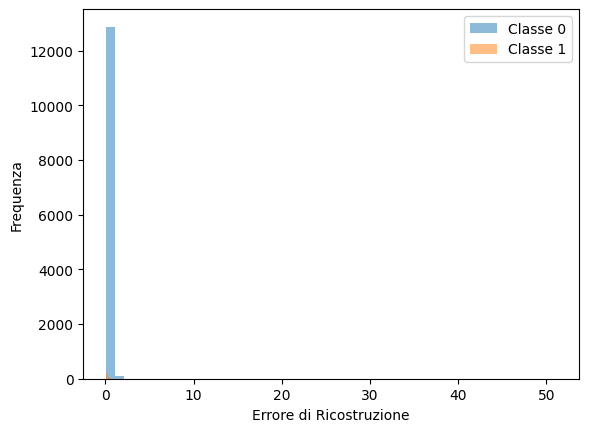

In [10]:
# Distribuzione degli errori di ricostruzione
plt.hist(reconstruction_error[y_test == 0], bins=50, alpha=0.5, label='Classe 0')
plt.hist(reconstruction_error[y_test == 1], bins=50, alpha=0.5, label='Classe 1')
plt.legend()
plt.xlabel('Errore di Ricostruzione')
plt.ylabel('Frequenza')
plt.show()

In [11]:
# 5. Valutazione delle performance
auc = roc_auc_score(y_test, reconstruction_error)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"AUC-ROC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

AUC-ROC: 0.5985
Precision: 0.1360
Recall: 0.0852
F1-Score: 0.1047
Confusion Matrix:
[[12370   610]
 [ 1031    96]]


IL MODELLO ATTUALMENTE FA SCHIFO! Possibili miglioramenti:
1) cambiare features considerate (aumentarle?) !!!
2) modificare training e test set?
3) modificare architettura della rete (numero layers, numero neuroni, activation function) !!!
4) cambiare optimizer (ora adam) o learning rate (adattivo?) e/o definizione loss !
5) cambiare numero di epoche (aggiungere early stopping) !
6) calibrare soglia per definire le anomalie !!